# Credit Score Detection

## Importing Libraries 

In [19]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE


## Get Dataset 

In [6]:
data = pd.read_csv("credit_customers.csv")
print(data)

    checking_status  duration                  credit_history  \
0                <0       6.0  critical/other existing credit   
1          0<=X<200      48.0                   existing paid   
2       no checking      12.0  critical/other existing credit   
3                <0      42.0                   existing paid   
4                <0      24.0              delayed previously   
..              ...       ...                             ...   
995     no checking      12.0                   existing paid   
996              <0      30.0                   existing paid   
997     no checking      12.0                   existing paid   
998              <0      45.0                   existing paid   
999        0<=X<200      45.0  critical/other existing credit   

                 purpose  credit_amount    savings_status  employment  \
0               radio/tv         1169.0  no known savings         >=7   
1               radio/tv         5951.0              <100      1<=X<4   


## One-hot-encoding and Binary encoding

One-hot-encoding all the natural language data with multiple values. For example housing values contains: Free, Rent, Owned. Converting those values into separate categories so that the model can be trained using those values. Binary encoded all the natural langauge data with only 2 distinct value types. EX: True/False can be represented as 0 and 1. 

In [7]:
features_to_encode = ["checking_status", "credit_history", "purpose", "savings_status", "other_payment_plans", 
                      "employment", "personal_status", "other_parties", "property_magnitude","housing", "job"] 
#One Hot Encoding
one_hot_encoded = pd.get_dummies(data[features_to_encode]) #Convert the targeted features into a encoded dataset.  
data = pd.concat([one_hot_encoded, data], axis=1) #Combine the encoded features into the main dataset.
data = data.drop(features_to_encode, axis=1) #Drop the features with natural language

#Convert all binary natural language features to 1 and 0. 
data['own_telephone']  = data['own_telephone'].replace({"none": 0, "yes": 1}) 
data['foreign_worker']  = data['foreign_worker'].replace({"no": 0, "yes": 1})
data['class']  = data['class'].replace({"bad": 0, "good": 1})
df = pd.DataFrame(data)
print(len(df.columns.tolist()))

60


## Scaling Data using StandardScalar

Scaling the data using Standard Scaling so that all features that large numeric values won't dominate the other features with small numeric values

In [8]:
columns_to_scale = ['num_dependents', 'existing_credits', 'age', 'residence_since',
                    'installment_commitment', 'credit_amount', 'duration'] #all features that are numeric values 


scaler = StandardScaler() #Using standard scaler
scaled = scaler.fit_transform(df[columns_to_scale]) #Transform all columns_to_scale features into Z-values in a matrix. 
scaled_columns = pd.DataFrame(scaled, columns=columns_to_scale, index=df.index) #make new dataset with the matrix
df[columns_to_scale] = scaled_columns #Replace all the columns_to_scale with the new data.
print(df)

     checking_status_0<=X<200  checking_status_<0  checking_status_>=200  \
0                           0                   1                      0   
1                           1                   0                      0   
2                           0                   0                      0   
3                           0                   1                      0   
4                           0                   1                      0   
..                        ...                 ...                    ...   
995                         0                   0                      0   
996                         0                   1                      0   
997                         0                   0                      0   
998                         0                   1                      0   
999                         1                   0                      0   

     checking_status_no checking  credit_history_all paid  \
0                         

## Data Class Percentage

Check the dataset class ratio. If the class ratio is unproportionate then when we train our models, the model might be biased. Unfortunately the the dataset is unproportionate.  

1    700
0    300
Name: class, dtype: int64


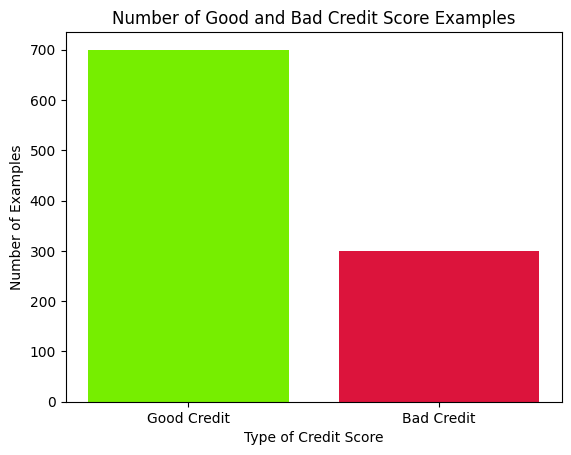

In [9]:
print(df["class"].value_counts()) #700 good credit risk, 300 bad credit risk

plt.bar((["Good Credit", "Bad Credit"]), ([700, 300]), color=['#76EE00', '#DC143C'])
plt.title('Number of Good and Bad Credit Score Examples')
plt.xlabel('Type of Credit Score')
plt.ylabel('Number of Examples')
plt.show()

## Data Splitting and Bias

Splitting the data to a 70% training data and 30% testing data. Also adding the bias in the dataset for w0. 

(700, 60) (300, 60) (700,) (300,)
491
209


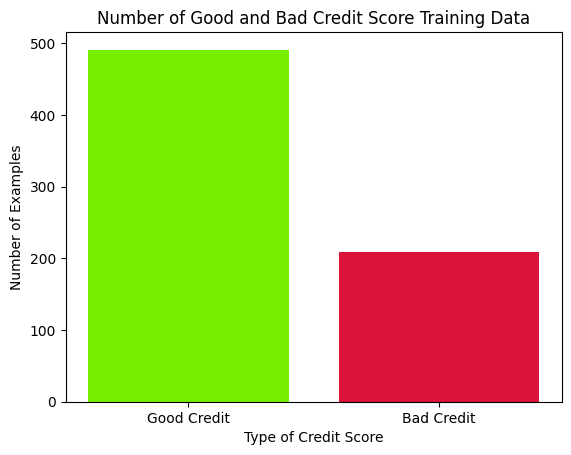

In [10]:
X = df.drop("class", axis = 1) #Drop the target variable
y = data["class"] #Get the target variable

X = np.array(X) #Tranform to a matrix
y = np.array(y) #Transform to a matrix

#adding bias
ones_column = np.ones((X.shape[0], 1)) 
X = np.hstack((ones_column, X))

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.30, random_state=42) #Splitting data to 70% training 30% testing

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#Imbalanced training set. There are 491 of 1 class and only 209 of the other class
print((y_train == 1).sum()) #491 
print((y_train == 0).sum()) #209
plt.bar((["Good Credit", "Bad Credit"]), ([491, 209]), color=['#76EE00', '#DC143C'])
plt.title('Number of Good and Bad Credit Score Training Data')
plt.xlabel('Type of Credit Score')
plt.ylabel('Number of Examples')
plt.show()

## SMOTE Technique 

To balance the number of good credit examples and the number of bad credit examples, we used the SMOTES to oversample the minority class, which is Bad Credit Risk. SMOTES algorithm basically uses pre-existing features from the training set to find which feature values make up a "Bad Credit Risk" example and used these features to make a synthetic example. This synthetic example is then added to the training data. 

491
491


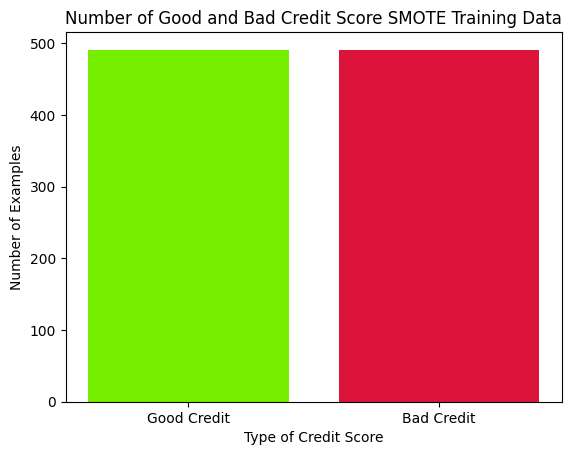

In [11]:
smote = SMOTE(random_state = 42) #Smotes technique
X_train, y_train = smote.fit_resample(X_train, y_train) #Oversample the minority class

#Equal number of bad and good class. :) 
print((y_train == 1).sum()) #491
print((y_train == 0).sum()) #491

plt.bar((["Good Credit", "Bad Credit"]), ([491, 491]), color=['#76EE00', '#DC143C'])
plt.title('Number of Good and Bad Credit Score SMOTE Training Data')
plt.xlabel('Type of Credit Score')
plt.ylabel('Number of Examples')
plt.show()

## Logistic Regression

Using logistic Regression to train our model. 
Experiments:
1. Use logistic regression with no transformation to train.
2. Use logistic regression with polynomial transformation to train.
3. Use the best dataset determined by the accuracy of step 1 and 2 and apply regularization and k-fold validation. 

### Polynomial Transformation


Transforming the data up to the 3rd degree using Logistic Regression. 

Degree 1: Training accuracy = 0.776, Test accuracy = 0.750, Number of Parameters = 60
Degree 2: Training accuracy = 1.000, Test accuracy = 0.733, Number of Parameters = 1890
Degree 3: Training accuracy = 1.000, Test accuracy = 0.730, Number of Parameters = 39710


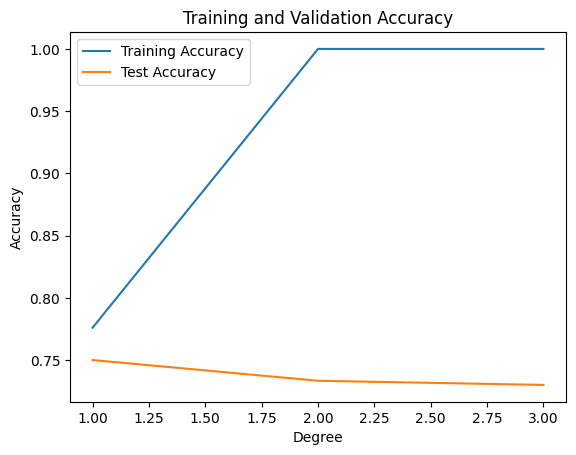

In [12]:
train_accuracy = []
test_accuracy = []

for i in range(3):
    polyTransform = PolynomialFeatures(degree=i+1, include_bias=False) #Set up polynomial transformation to the ith degree
    X_train_poly = polyTransform.fit_transform(X_train) #Transform the training data
    X_test_poly = polyTransform.transform(X_test)  #Transform the test data
    
    logisticRegr = LogisticRegression(max_iter = 100000) #Use logistic regression using a maximum of 100000 iterations. 
    logisticRegr.fit(X_train_poly, y_train) #Fit the model 
    
    y_pred_train = logisticRegr.predict(X_train_poly) #Predict the target variable of each example in the training set
    accuracy_train = accuracy_score(y_train, y_pred_train)  #Calculate accuracy on training set
    train_accuracy.append(accuracy_train)
    
    y_pred_test = logisticRegr.predict(X_test_poly) #Predict the target variable of each example in the testing set
    accuracy_test = accuracy_score(y_test, y_pred_test)  #Calculate accuracy on test set
    test_accuracy.append(accuracy_test)
    
    print(f"Degree {i+1}: Training accuracy = {accuracy_train:.3f}, Test accuracy = {accuracy_test:.3f}, Number of Parameters = {X_train_poly.shape[1]}")

    
plt.plot([1,2,3], train_accuracy, label='Training Accuracy')
plt.plot([1,2,3], test_accuracy, label='Test Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



### Regularization with K-fold validation

Since the dataset with no transformation performed the best we will be using that dataset for regularization, k-fold validation, and logistic regression. 

The regularization techniques that will be used is L1(Lasso) and L2(Ridge). 

Using up to 10 folds for k-fold validation with a lamda parameter of [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000]. 

Penalty: ('l1', 'liblinear'), Folds: 2, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 3, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 4, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 5, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 6, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 7, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 8, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 9, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 10, Best C Value: 100.0
Training accuracy: 0.775
Test accuracy: 0.763



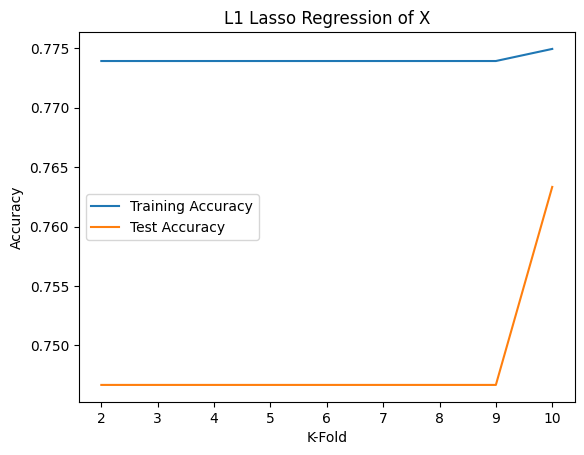

Penalty: ('l2', 'lbfgs'), Folds: 2, Best C Value: 0.1
Training accuracy: 0.767
Test accuracy: 0.727

Penalty: ('l2', 'lbfgs'), Folds: 3, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750

Penalty: ('l2', 'lbfgs'), Folds: 4, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750

Penalty: ('l2', 'lbfgs'), Folds: 5, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750

Penalty: ('l2', 'lbfgs'), Folds: 6, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750

Penalty: ('l2', 'lbfgs'), Folds: 7, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750

Penalty: ('l2', 'lbfgs'), Folds: 8, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750

Penalty: ('l2', 'lbfgs'), Folds: 9, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750

Penalty: ('l2', 'lbfgs'), Folds: 10, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750



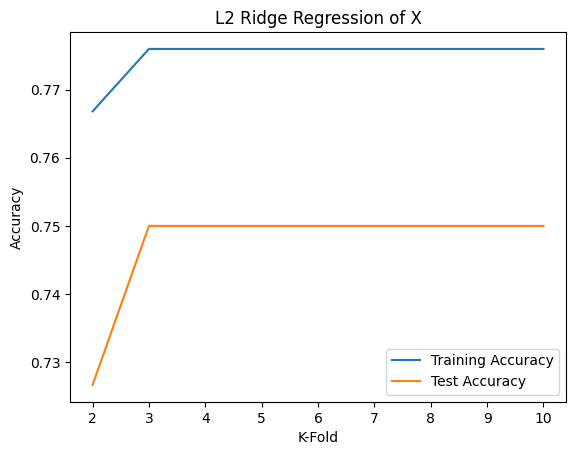

In [13]:
k = 2 #starting fold
penalty_reg =[("l1", "liblinear"), ("l2",'lbfgs')] #type of regularization technique
C = [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000] #Lambda values

for i in penalty_reg: 
    train_accuracy = [] 
    test_accuracy = []
    best_C = []
    for a in range(9):
        #cv = check how many folds, penalty = type of regularization, Cs= lambda values
        #Logisitc regression model with k-folds, and regularization type
        logisticRegrCV = LogisticRegressionCV(cv=k+a, penalty=i[0], random_state=42, max_iter = 100000, solver=i[1],Cs = C) 
        logisticRegrCV.fit(X_train, y_train) #Fit the model 
        
        y_pred_train = logisticRegrCV.predict(X_train) #Predict the target variable of each example in the training set
        accuracy_train = accuracy_score(y_train, y_pred_train) #Calculate accuracy on training set
        train_accuracy.append(accuracy_train)
        
        y_pred_test = logisticRegrCV.predict(X_test) #Predict the target variable of each example in the training set
        accuracy_test = accuracy_score(y_test, y_pred_test) #Calculate accuracy on testing set
        test_accuracy.append(accuracy_test)
        
        best_C.append(logisticRegrCV.C_[0])
        
        print(f"Penalty: {i}, Folds: {k+a}, Best C Value: {logisticRegrCV.C_[0]}")
        print(f"Training accuracy: {accuracy_train:.3f}")
        print(f"Test accuracy: {accuracy_test:.3f}")
        print()
        
    plt.plot([2,3,4,5,6,7,8,9,10], train_accuracy, label='Training Accuracy')
    plt.plot([2,3,4,5,6,7,8,9,10], test_accuracy, label='Test Accuracy')
    if i[0] == "l1":
        plt.title("L1 Lasso Regression of X")
    else:
        plt.title("L2 Ridge Regression of X")
    plt.xlabel('K-Fold')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


# SVM

In [14]:
# try different kernels
for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    clf = SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    # print(clf.support_vectors_)

    accuracy_train = clf.score(X_train, y_train)
    accuracy_test  = clf.score(X_test, y_test)

    print(f"{kernel=},\t {accuracy_train=:.3f},\t {accuracy_test=:.3f}")

kernel='linear',	 accuracy_train=0.791,	 accuracy_test=0.730
kernel='poly',	 accuracy_train=0.945,	 accuracy_test=0.750
kernel='rbf',	 accuracy_train=0.912,	 accuracy_test=0.737
kernel='sigmoid',	 accuracy_train=0.653,	 accuracy_test=0.667


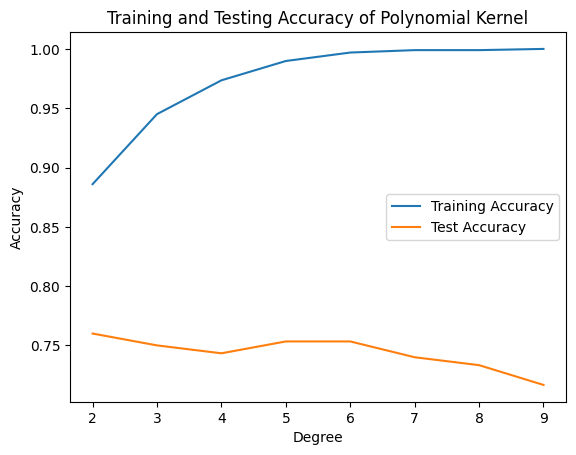

In [15]:
# Plot training/testing accuracy on poly kernel with varying degrees and C=1
test_accuracy  = []
train_accuracy = []
for degree in range(2, 10):
    clf = SVC(kernel="poly", degree=degree)
    clf.fit(X_train, y_train)

    accuracy_train = clf.score(X_train, y_train)
    accuracy_test  = clf.score(X_test, y_test)

    train_accuracy.append(accuracy_train)
    test_accuracy.append(accuracy_test)

plt.plot(range(2, 10), train_accuracy, label='Training Accuracy')
plt.plot(range(2, 10), test_accuracy, label='Test Accuracy')
plt.title('Training and Testing Accuracy of Polynomial Kernel')
plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
# k-fold cross validation with different C values
for kernel in ["poly", "rbf", "sigmoid"]:
    for kfold in range(2, 10):
        for degree in range(2, 10):
            best_mean_for_c = (0, "")
            for c in [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000]:
                clf = SVC(kernel=kernel, C=c, degree=degree)
                clf.fit(X_train, y_train)  # train on train set
                scores = cross_val_score(clf, X_test, y_test, cv=kfold)  # test on test set
                if scores.mean() > best_mean_for_c[0]:
                    best_mean_for_c = (scores.mean(), f"{kernel=} {degree=} {kfold=} {c=},\t acc mean:{scores.mean():.3f},\t acc std:{scores.std():.3f},\t {scores=}")
                if kernel != "poly":
                    break
        print(best_mean_for_c[1])

kernel='poly' degree=9 kfold=2 c=1,	 acc mean:0.710,	 acc std:0.003,	 scores=array([0.70666667, 0.71333333])
kernel='poly' degree=9 kfold=3 c=0.1,	 acc mean:0.707,	 acc std:0.009,	 scores=array([0.7 , 0.72, 0.7 ])
kernel='poly' degree=9 kfold=4 c=1,	 acc mean:0.710,	 acc std:0.011,	 scores=array([0.69333333, 0.72      , 0.72      , 0.70666667])
kernel='poly' degree=9 kfold=5 c=1,	 acc mean:0.713,	 acc std:0.024,	 scores=array([0.68333333, 0.75      , 0.7       , 0.73333333, 0.7       ])
kernel='poly' degree=9 kfold=6 c=1,	 acc mean:0.717,	 acc std:0.018,	 scores=array([0.7 , 0.74, 0.72, 0.74, 0.7 , 0.7 ])
kernel='poly' degree=9 kfold=7 c=1,	 acc mean:0.720,	 acc std:0.023,	 scores=array([0.72093023, 0.74418605, 0.74418605, 0.69767442, 0.74418605,
       0.69767442, 0.69047619])
kernel='poly' degree=9 kfold=8 c=1,	 acc mean:0.713,	 acc std:0.025,	 scores=array([0.68421053, 0.68421053, 0.76315789, 0.71052632, 0.72972973,
       0.72972973, 0.7027027 , 0.7027027 ])
kernel='poly' degree=9 

In [21]:
# test different regularization with linear SVC
for kfold in range(2, 10):
    best_mean_for_c = (0, "")
    for penalty in [("l1", "squared_hinge"), ("l2", "squared_hinge")]:
        # for c in [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000]:
        c = 1
        clf = LinearSVC(penalty=penalty[0], loss=penalty[1], C=c, dual=False)
        clf.fit(X_train, y_train)  # train on train set
        scores = cross_val_score(clf, X_test, y_test, cv=kfold)  # test on test set
        if scores.mean() > best_mean_for_c[0]:
            best_mean_for_c = (scores.mean(), f"{penalty=} {kfold=} {c=},\t acc mean:{scores.mean():.3f},\t acc std:{scores.std():.3f},\t {scores=}")
    print(best_mean_for_c[1])

penalty=('l2', 'squared_hinge') kfold=2 c=1,	 acc mean:0.763,	 acc std:0.037,	 scores=array([0.8       , 0.72666667])
penalty=('l2', 'squared_hinge') kfold=3 c=1,	 acc mean:0.727,	 acc std:0.037,	 scores=array([0.77, 0.68, 0.73])
penalty=('l2', 'squared_hinge') kfold=4 c=1,	 acc mean:0.767,	 acc std:0.031,	 scores=array([0.74666667, 0.81333333, 0.73333333, 0.77333333])
penalty=('l2', 'squared_hinge') kfold=5 c=1,	 acc mean:0.717,	 acc std:0.028,	 scores=array([0.71666667, 0.73333333, 0.66666667, 0.71666667, 0.75      ])
penalty=('l2', 'squared_hinge') kfold=6 c=1,	 acc mean:0.743,	 acc std:0.045,	 scores=array([0.72, 0.76, 0.74, 0.8 , 0.66, 0.78])


c:\Users\calvi\.pyenv-win-venv\envs\4563\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\calvi\.pyenv-win-venv\envs\4563\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\calvi\.pyenv-win-venv\envs\4563\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\calvi\.pyenv-win-venv\envs\4563\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


penalty=('l1', 'squared_hinge') kfold=7 c=1,	 acc mean:0.724,	 acc std:0.048,	 scores=array([0.74418605, 0.69767442, 0.79069767, 0.69767442, 0.65116279,
       0.69767442, 0.78571429])
penalty=('l2', 'squared_hinge') kfold=8 c=1,	 acc mean:0.753,	 acc std:0.045,	 scores=array([0.76315789, 0.73684211, 0.84210526, 0.73684211, 0.78378378,
       0.67567568, 0.72972973, 0.75675676])
penalty=('l2', 'squared_hinge') kfold=9 c=1,	 acc mean:0.736,	 acc std:0.056,	 scores=array([0.76470588, 0.79411765, 0.76470588, 0.75757576, 0.63636364,
       0.72727273, 0.63636364, 0.75757576, 0.78787879])


c:\Users\calvi\.pyenv-win-venv\envs\4563\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\calvi\.pyenv-win-venv\envs\4563\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\calvi\.pyenv-win-venv\envs\4563\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


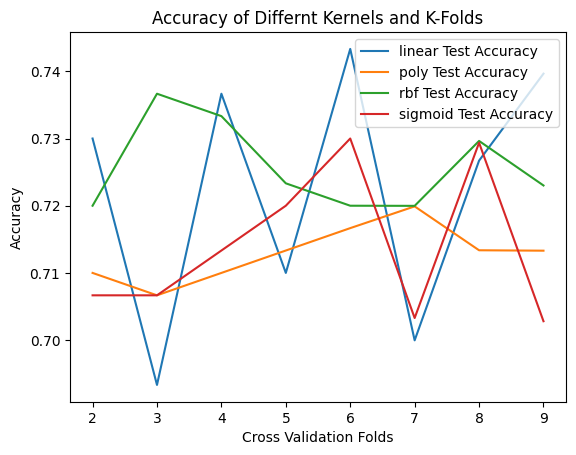

In [22]:
# Plot training/testing accuracy on all kernel with varying kfold
from collections import defaultdict

training_accuracy = defaultdict(list)
testing_accuracy  = defaultdict(list)

# k-fold cross validation with different C values
for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    for kfold in range(2, 10):
        c = 1
        clf = SVC(kernel=kernel, C=c, degree=degree)
        clf.fit(X_train, y_train)  # train on train set
        train_accuracy = accuracy_score(y_train, clf.predict(X_train))
        test_accuracy  = cross_val_score(clf, X_test, y_test, cv=kfold).mean()  # test on test set
        training_accuracy[kernel].append(train_accuracy)
        testing_accuracy[kernel].append(test_accuracy)

for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    # plt.plot(range(2, 10), training_accuracy[kernel], label=f'{kernel} Training Accuracy')
    plt.plot(range(2, 10), testing_accuracy[kernel], label=f'{kernel} Test Accuracy')
plt.title('Accuracy of Differnt Kernels and K-Folds')
plt.xlabel('Cross Validation Folds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
